# Random Forest Baseline - LB 0.664
In this notebook we present a Random Forest baseline. We train GroupKFold models for each of the 18 questions. Our CV score is 0.664. We infer test using one of our KFold models. We can improve our CV and LB by engineering more features for our random forest and/or trying different models (like other ML models and/or RNN and/or Transformer). Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [2]:
train = pd.read_csv('../../data/train.csv.gz', compression='gzip')
print( train.shape )
train.head()

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [3]:
targets = pd.read_csv('../../data/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB!

In [4]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [5]:
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [6]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 22)
CPU times: user 14.4 s, sys: 10.8 ms, total: 14.4 s
Wall time: 14.4 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [7]:
df.dtypes

level_group            object
event_name_nunique      int64
name_nunique            int64
fqid_nunique            int64
room_fqid_nunique       int64
text_fqid_nunique       int64
elapsed_time          float64
level                 float64
page                  float64
room_coor_x           float64
room_coor_y           float64
screen_coor_x         float64
screen_coor_y         float64
hover_duration        float64
elapsed_time_std      float64
level_std             float64
page_std              float64
room_coor_x_std       float64
room_coor_y_std       float64
screen_coor_x_std     float64
screen_coor_y_std     float64
hover_duration_std    float64
dtype: object

# Train Random Forest Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [9]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 21 features
We will train with 11779 users info


In [10]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier() 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [12]:
models

{'0-4_1': RandomForestClassifier(),
 '0-4_2': RandomForestClassifier(),
 '0-4_3': RandomForestClassifier(),
 '5-12_4': RandomForestClassifier(),
 '5-12_5': RandomForestClassifier(),
 '5-12_6': RandomForestClassifier(),
 '5-12_7': RandomForestClassifier(),
 '5-12_8': RandomForestClassifier(),
 '5-12_9': RandomForestClassifier(),
 '5-12_10': RandomForestClassifier(),
 '5-12_11': RandomForestClassifier(),
 '5-12_12': RandomForestClassifier(),
 '5-12_13': RandomForestClassifier(),
 '13-22_14': RandomForestClassifier(),
 '13-22_15': RandomForestClassifier(),
 '13-22_16': RandomForestClassifier(),
 '13-22_17': RandomForestClassifier(),
 '13-22_18': RandomForestClassifier()}

In [13]:
oof.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,0.77,0.99,0.95,0.83,0.73,0.92,0.84,0.74,0.86,0.62,0.79,0.89,0.61,0.77,0.52,0.76,0.65,0.99
20090312433251036,0.64,0.94,0.94,0.54,0.25,0.59,0.54,0.52,0.57,0.38,0.65,0.76,0.26,0.51,0.30,0.53,0.60,0.74
20090314121766812,0.51,0.97,0.86,0.93,0.58,0.83,0.80,0.63,0.79,0.49,0.65,0.94,0.12,0.78,0.64,0.80,0.82,0.99
20090314363702160,0.76,1.00,0.99,0.88,0.73,0.96,0.93,0.87,0.86,0.73,0.78,0.90,0.30,0.68,0.40,0.83,0.65,0.93
20090314441803444,0.75,0.97,0.96,0.77,0.59,0.87,0.71,0.71,0.70,0.68,0.73,0.88,0.36,0.80,0.51,0.74,0.77,1.00


# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [14]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [15]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

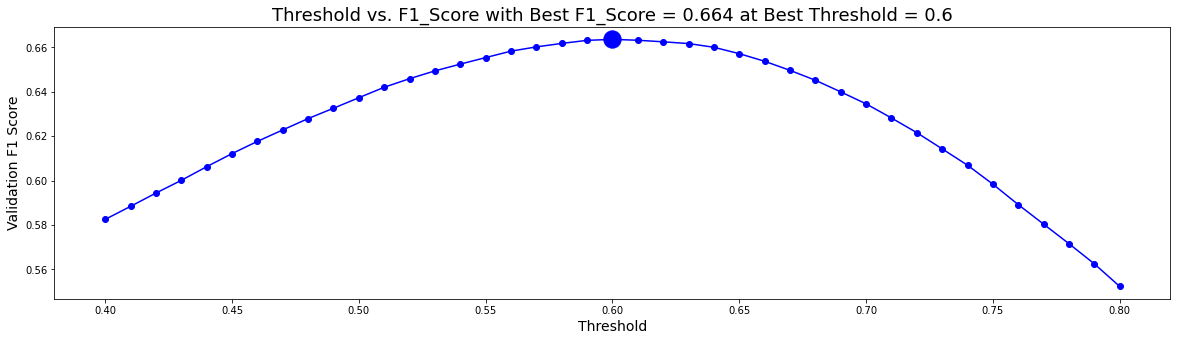

In [16]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [17]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5394894024986673
Q1: F1 = 0.49457198026174637
Q2: F1 = 0.4857862280792049
Q3: F1 = 0.5806756118152119
Q4: F1 = 0.5564465888496599
Q5: F1 = 0.5842766992499013
Q6: F1 = 0.5703349125094312
Q7: F1 = 0.5375760951240417
Q8: F1 = 0.5792245893688296
Q9: F1 = 0.5167756198568199
Q10: F1 = 0.5643943013644164
Q11: F1 = 0.4896630899309197
Q12: F1 = 0.4384030262081462
Q13: F1 = 0.5889393870770318
Q14: F1 = 0.49502951453230554
Q15: F1 = 0.4827064888237284
Q16: F1 = 0.5276941226262823
Q17: F1 = 0.4889197006580287
==> Overall F1 = 0.6635966167481159


# Infer Test Data

In [13]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [14]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# EDA submission.csv

In [15]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,0
4,20090312143683264_q2,1


In [16]:
print(df.correct.mean())

0.6481481481481481
